What is the error rate of the model for predicting a category?


In [1]:
import sys
sys.path.append('../bin')

from pprint import pprint
import matplotlib.pyplot as plt

import utils
import constants as c


In [2]:
def get_labeled_nodes(cat):
    labeled = set()
    for c in cat:
        for m in c.edges:
            labeled.add(m)
    return labeled

def mean(s):
    return sum([x for x in s]) / len(s)

def diff_sq(s):
    return [(x - mean(s))**2 for x in s]

def variance(s):
    return sum(diff_sq(s)) / len(s)

def score_category(graph, cat, all_labeled_nodes):
    # Score is misses / (hits + misses)
    scores = []
    for m in cat.edges:
        A = graph[m]
        hits = []
        misses = []
        for token, score in A.similar:        
            # Hits: token is in cat.edges
            if token in cat.edges:
                hits.append(score)
            # Misses: token is labeled but not as this category
            if token in all_labeled_nodes and token not in cat.edges:
                misses.append(score)
        if len(misses) + len(hits) == 0:
            # Return 1 for a full on error
            score = 1
        else:
            score = len(misses) / (len(hits) + len(misses)) 
        scores.append(score)
    
        
    return {'cat': cat.id, 'mean': mean(scores), 'variance': variance(scores), 'scores': scores}

def report(lines):
    print(f'{"Category":<15s} {"Mean":>14s} {"Variance":>14s} {"N":>3s}')
    print('---------------------------------------------------')
    for line in lines:
        print(f"{line['cat']:<25s} {line['mean']:<10f} {line['variance']:<10f} {len(line['scores']):<10d}")


## Scores by category

In [3]:
pickle = '2020713-moma-exhibitions-categories-word2vec.pickle'
graph = utils.load_graph(c.PROJECT_DATA_PICKLES.joinpath(pickle))

In [4]:
nodes = graph.get_nodes()
categories = nodes['Category'].values()
labeled_nodes = get_labeled_nodes(categories)    

scores_by_category = []

for category in categories: 
    if category.degrees > 1:
        scores_by_category.append(score_category(graph, category, labeled_nodes))

report(scores_by_category)

Category                  Mean       Variance   N
---------------------------------------------------
Post-Impressionism        0.856376   0.019417   15        
Symbolism                 0.748181   0.088153   12        
Pont-Aven School          1.000000   0.000000   4         
synthetism                1.000000   0.000000   2         
Cloisonnism               1.000000   0.000000   2         
expressionism             0.754934   0.045945   46        
Impressionism             0.940043   0.007377   11        
pointillism               0.916005   0.008821   6         
Precisionism              1.000000   0.000000   4         
American realism          1.000000   0.000000   2         
Cubism                    0.922222   0.008266   13        
fauvism                   0.944444   0.024691   9         
divisionism               1.000000   0.000000   2         
surrealism                0.860444   0.049937   25        
Les Nabis                 1.000000   0.000000   4         
abstract expr

## All scores 

In [5]:
all_scores = []

for category in categories: 
    if category.degrees > 1:
        cat_score = score_category(graph, category, labeled_nodes)['scores']
        for x in cat_score:
            all_scores.append(x)

line = {'cat': 'all', 'mean': mean(all_scores), 'variance': variance(all_scores), 'scores': all_scores}

report([line])

Category                  Mean       Variance   N
---------------------------------------------------
all                       0.828624   0.068202   492       


(array([ 20.,  21.,  30.,  36.,  47.,  90., 113., 146., 206., 492.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

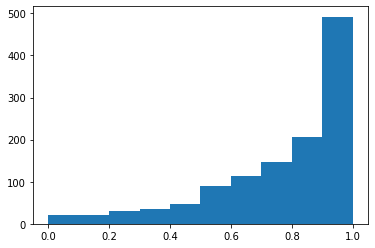

In [6]:
plt.hist(all_scores, cumulative=True)
